<a href="https://colab.research.google.com/github/MartinSJ2407/MartinSJ24/blob/main/Copy_of_Curbo_Recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
USER_SIZE = 60827
CAR_SIZE = 357

def build_rating_sparse_tensor(car_df):
  indices = car_df[['user', 'cars']].values
  return tf.SparseTensor(
      indices=indices,
      values=np.ones(indices.shape[0]),
      dense_shape=[USER_SIZE, CAR_SIZE])

def sparse_mean_square_error(sparse_ratings, user_embeddings, car_embeddings):
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, car_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss


# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [ ]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [ ]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  train_ratings, test_ratings = split_dataframe(ratings)
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "car_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [ ]:
import json

with open('/content/ids_to_int_dom.json', 'r') as f:
    json_str = ''.join(f.readlines())

mapping = json.loads(json_str)

ratings = pd.read_csv('/content/user_preferences_dom.csv')

ratings = ratings.replace(mapping['car_id_to_int']).replace(mapping['user_id_to_int'])

ratings.sample(5)

,user,cars
463,59294,168
422,58677,108
210,32426,28
796,60593,99
387,57172,203


In [ ]:
ratings['car_id_to_int'] = ratings.cars.astype('str').str.isnumeric()
ratings['user_id_to_int'] = ratings.user.astype('str').str.isnumeric()


In [ ]:
ratings = ratings[ratings['car_id_to_int'] & ratings['user_id_to_int']]

In [ ]:
ratings = ratings[['user', 'cars']]

 iteration 1500: train_error=0.019285, test_error=3.608815

[{'train_error': 0.0192852, 'test_error': 3.6088152}]

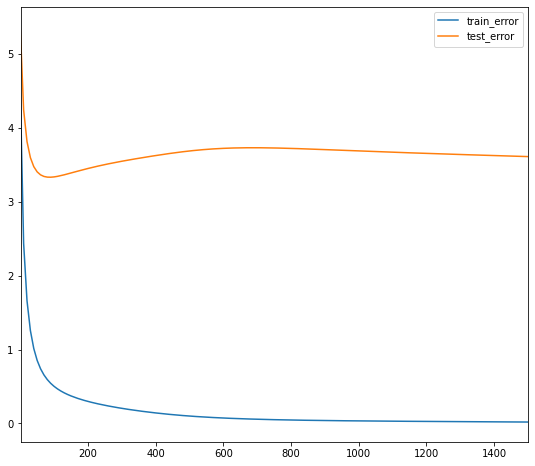

In [ ]:
model = build_model(ratings, embedding_dim=3, init_stddev=1.)
model.train(num_iterations=1500, learning_rate=1.)

In [ ]:
import pickle

with open('embeddings_dom.pickle','wb') as file:
    pickle.dump(model.embeddings, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model.embeddings

{'user_id': array([[-1.0677158 , -1.2083259 ,  0.33303604],
        [-0.0645261 , -0.40887088,  1.2989862 ],
        [ 0.67432785,  0.7370346 , -0.99643517],
        ...,
        [ 0.93654233,  0.22038841,  0.29188302],
        [-1.3999937 ,  0.299904  ,  0.56201214],
        [-0.6257756 ,  0.26561373,  1.1079655 ]], dtype=float32),
 'car_id': array([[ 1.7691284 ,  0.28070208,  0.48812786],
        [-0.20412117,  0.2710758 ,  0.70489055],
        [-1.1269754 , -0.5996123 ,  0.83012545],
        ...,
        [ 0.10950056,  0.6092808 , -0.33323026],
        [ 1.9859782 , -0.82273453,  1.41723   ],
        [-2.6762445 ,  1.4325372 , -0.8142165 ]], dtype=float32)}

In [ ]:
embeddings_path = '/content/embeddings_dom.pickle'

with open(embeddings_path, 'rb') as file:
    embeddings = pickle.load(file)

embeddings

{'user_id': array([[-1.0677158 , -1.2083259 ,  0.33303604],
        [-0.0645261 , -0.40887088,  1.2989862 ],
        [ 0.67432785,  0.7370346 , -0.99643517],
        ...,
        [ 0.93654233,  0.22038841,  0.29188302],
        [-1.3999937 ,  0.299904  ,  0.56201214],
        [-0.6257756 ,  0.26561373,  1.1079655 ]], dtype=float32),
 'car_id': array([[ 1.7691284 ,  0.28070208,  0.48812786],
        [-0.20412117,  0.2710758 ,  0.70489055],
        [-1.1269754 , -0.5996123 ,  0.83012545],
        ...,
        [ 0.10950056,  0.6092808 , -0.33323026],
        [ 1.9859782 , -0.82273453,  1.41723   ],
        [-2.6762445 ,  1.4325372 , -0.8142165 ]], dtype=float32)}